# Description

In this notebook i will plot all data, which are must be plot for the protocoll.

# Importe

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# the rest
from matplotlib.font_manager import FontProperties
import requests
from sdtfile.sdtfile import SdtFile
import os

# Regression
from scipy.optimize import curve_fit
import statsmodels.api as sm
import scipy as sp
import lifefit as lf
import scipy.stats as stats

# Functions

In [62]:
class math_func():
    def af(N0, t, t0, tau=4.9e-9):
        N = N0 * np.exp(-(t - t0) / tau)
        return N

    def snr(Nmax, Nrausch):
        snr = (Nmax - Nrausch) / Nrausch
        return snr

    def anisotropie(I_par, I_ortho):
        """
          I_par:      parallele Intensität
          I_ortho:    orthogonale Intensität
        """
        r = (I_par - I_ortho) / (I_par + 2 * I_ortho)
        return r

    def mse(y, y_hat):
        """
        y must be an array
        """
        ms_error = (y - y_hat)**2 / len(y)
        return ms_error.sum(), len(y)

    def rmse(y, y_hat):
        ms, _ = math_func.mse(y, y_hat)
        rms = np.sqrt(ms)
        return rms


class fpr():
    def creating_folder(fn='New-Folder'):
        for i in range(1, 30):
            path = f'/content/{fn}_{i}'
            if not os.path.exists(path):
                os.makedirs(path, exist_ok=True)
            return path

    def download_asc(self, url_list, name_list, foldername):
        if len(url_list) == len(name_list):
            new_folder_path = self.creating_folder(foldername)
            if new_folder_path:
                print(f"New folder created at: {new_folder_path}")
            else:
                print(f"Error creating folder for fn in the creating_folder function. Maximum limit reached.")
        else:
            print("Error: The lists don't have the same length. Change it")

#   def download_csv(link,filename,ind=0,h=0):
#     !wget {link}
#     df = pd.read_csv(f'/content/{filename}',index_col=ind,header=0)
#     return df

    def download_file(url, save_path):
        response = requests.get(url)
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded to {save_path}")

    def get_excel_sheet_info(file_path):
        xl = pd.ExcelFile(file_path)
        sheet_count = len(xl.sheet_names)
        sheet_names = xl.sheet_names
        return sheet_count, sheet_names

    def sheet_transform(filename, list_of_sheets):
        lst_of_df = []
        for i in range(len(list_of_sheets)):
            df = pd.read_excel(filename, list_of_sheets[i])
            df = df.drop(0)
            df = df.T
            df.index = range(len(df))
            df.columns = df.iloc[0]
            df = df.drop(0)
            df.index = range(len(df))
            lst_of_df.append(df)
        return lst_of_df

    # def df_into_csv_list(list_of_df,folder_path,name_of_csv):
    #     """
    #     Needed Packages:        os, google.colab.files
    #     Description:            This function is for a list of
    #                             data frames
    #     """
    #     # needs the packages os and google.colab.files
    #     if len(list_of_df) == len(name_of_csv):
    #         for i in range(len(list_of_df)):
    #             list_of_df[i].to_csv(os.path.join(folder_path, f"{name_of_csv[i]}.csv"),
    #                                  index=False,
    #                                  encoding='utf-8-sig')
    #             files.download(f'{folder_path}/{name_of_csv[i]}.csv')
    #     else:
    #         print('Both lists have not the same length!')

    def df_into_csv(df, path, name_of_csv):
        df.to_csv(os.path.join(path, f"{name_of_csv}.csv"),
                index=False, encoding='utf-8-sig')

    def list_of_df_from_folder(folder_path):
        """
        Needed Packges: os, pandas as pd
        """
        csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        df_list = []
        for file in csv_files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            df_list.append(df)
        return df_list

    def asc_files(folder_path):
        """
        Needed Packages: os, numpy as np
        """

        asc_files = [f for f in os.listdir(folder_path) if f.endswith('.asc')]
        return asc_files

    def asc_to_array(folder_path):
        # using files
        asc_files = fpr.asc_files(folder_path)

        dt_lists = []
        for i in range(len(asc_files)):
            data = []
            file_path = os.path.join(folder_path,asc_files[i])
            with open(file_path,'r') as f:
                for line in f:
                    try:
                        # attempt to convert the line to floats
                        values = [float(val) for val in line.split()]
                        data.append(values)
                    except ValueError:
                        continue

            dt_lists.append(data)

        return dt_lists

    def list_of_filenames(folder_path):
        """
        Packages: os
        Function to get the filenames without file ending
        """
        all_files = os.listdir(folder_path)
        file_names = [os.path.splitext(file)[0] for file in all_files]
        return file_names

    def sdt_cfd_sw(folder_path):
        """
        Packages: os, sdtfile.sdtfile.SdtFile
        """
        sdt_files = [f for f in os.listdir(folder_path) if f.endswith('.sdt')]

        dfs = []
        file_names = []
        for file in sdt_files:
            # getting file names
            name = os.path.splitext(file)[0]
            file_names.append(name)
            # getting data
            fp = os.path.join(folder_path, file)
            sdt = SdtFile(fp)
            data = sdt.data[0][0]
            dfs.append(data)

        return dfs, file_names

    def data_frame(list_of_arrays, col_names, path, file_name):
        """
        Creating from a list of arrays a data frame.

        Each Array must have a length of 1024 elements.

        List of arrays:       list_of_arrays
        Column names:         col_names
        Folder path:          path
        CSV file name:        file name
        """
        # Creating Data Frame
        time = np.linspace(0, 25, 1024)
        df = pd.DataFrame(list_of_arrays).T
        df.columns = col_names
        df['Time'] = time

        # Creating CSV File
        fpr.df_into_csv(df, path, file_name)

        # return data frame
        return df

    def plotting_spc(df, col_names, label=''):
        """
        Packages: matplotlib.pyplot as plt
        """
        # plotting
        x = df['Time']
        for i in col_names:
            y = df[i]
            plt.plot(x, y, label=label + f' {i}')
        plt.xlabel('Time [ns]')
        plt.ylabel('Counts')
        plt.yscale('log')
        plt.legend(loc='center right', bbox_to_anchor=(1.4, .5))

        # showing
        plt.show()

    def plotting_gen_with_labels(df, col_names, labels):
        """
        Packages: matplotlib.pyplot as plt
        """
        # plotting
        x = df['Time']
        for i in range(len(labels)):
            y = df[col_names[i]]
            plt.plot(x, y, label=labels[i])
        plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
        plt.ylabel('Counts', fontsize=14, fontweight='bold')
        plt.yscale('log')

        # Customize legend font size and weight
        fontP = FontProperties()
        fontP.set_size('large')  # Adjust 'large' as needed
        fontP.set_weight('bold')

        # Add a legend with custom font size and weight
        plt.legend(loc='center right', bbox_to_anchor=(1.25, .5), prop=fontP)

        # showing
        plt.show()

    def sdt_generall(path):
        sdt_files = [f for f in os.listdir(path) if f.endswith('.sdt')]
        fp = os.path.join(path, sdt_files[0])
        sdt = SdtFile(fp)
        data = sdt.data
        dim = len(data)

        file_names = []
        dfs = []
        for i in range(dim):
            nl = []
            dfs.append(nl)

        for file in sdt_files:
            # getting file names
            name = os.path.splitext(file)[0]
            file_names.append(name)
            # getting data
            fp = os.path.join(path, file)
            sdt = SdtFile(fp)
            data = sdt.data
            for i in range(len(data)):
                dfs[i].append(data[i][0])

        return dfs, file_names

#   def new_folder_for_files(list_of_files,new_folder_path):
#     """
#     Packages: shutil, os
#     """
#     # creating folder:
#     os.makedirs(new_folder_path,exist_ok=True)

#     # putting files in new folder
#     s_f = '/content'
#     for file in list_of_files:
#       s_p = os.path.join(s_f,file)
#       d_p = os.path.join(new_folder_path,file)
#       shutil.move(s_p,d_p)


In [63]:
# creating folder for plots
# folder_name = 'Plots'
# data_path = '../Data/'
# path = fpr.creating_folder(folder_name)

# Graphes
## needed plots
- Apparatefunction
- Peak-Pile-Up
- Reab
- Fluoresenzlebensdauer
- Pheo
- Triton
- Anisotropie (all)

## needed residuen
- Peak-Pile-Up
- Fluoresenzlebensdauer (Reab) from the experiment computer

# Excel Data

In [66]:
data_path = '../Data/'

## Einbettung Miz

In [67]:
excel_file_path = data_path + 'SPC_Daten.xlsx'
sheet_count, sheet_names = fpr.get_excel_sheet_info(excel_file_path)
sheet_names

['1 SNR CFD',
 '2 PMT',
 '2.2 Laserint',
 '3 PileUp',
 '4 Reabsorp',
 '5 Pheo in EthWass',
 '6 EinbettMiz']

In [125]:
df_miz = pd.read_excel(excel_file_path, sheet_names[6])
df_miz.index = list(df_miz['Index'])
df_miz = df_miz.drop('Index', axis=1).T
df_miz

,chi^2,t in ns,Mischungsverhältnis P : W : E
ohne Triton X100,3.201,0.0012,NaN
mit Triton X100,14.49,3.3038,1:4:0


In [126]:
MV_140_mz = df_miz['Mischungsverhältnis P : W : E'][1]
tau_miz = 3.3038

C:\Users\benjf\AppData\Local\Temp\ipykernel_30076\1521030400.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  MV_140_mz = df_miz['Mischungsverhältnis P : W : E'][1]


## Pile UP

In [83]:
df_s_pu = pd.read_excel(excel_file_path, sheet_names[3])
df_s_pu.index = df_s_pu['Pile up Effekt']
df_s_pu = df_s_pu.T
df_s_pu = df_s_pu.drop('Pile up Effekt')
df_s_pu = df_s_pu.drop(np.nan, axis=1)
index = len(df_s_pu)
df_s_pu.index = range(index)
df_s_pu.Name = None

df_s_pu

Pile up Effekt,Position,Counts,chi^2,t in ns,HWSM
0,4.5,65792.0,1.234,4.59,2.4809
1,4.6,91146.0,1.445,4.74,2.5408
2,4.7,224322.0,2.358,4.92,2.4949
3,4.8,377627.0,3.57,5.0,2.5504
4,4.9,610481.0,5.031,5.05,2.7119
5,5.0,852527.0,7.282,5.06,2.5777
6,5.1,954268.0,8.25,5.09,2.7108
7,5.2,52944.0,1.304,4.46,1.3917
8,5.3,264114.0,2.972,4.97,2.6425


In [54]:
df_sheet_pu = df_s_pu
df_sheet_pu = df_sheet_pu.rename(columns={
    'Position': 'Pos',
    't in ns': 'tau [ns]'
})
df_sheet_pu

Pile up Effekt,Pos,Counts,chi^2,tau [ns],HWSM
0,4.5,65792.0,1.234,4.59,2.4809
1,4.6,91146.0,1.445,4.74,2.5408
2,4.7,224322.0,2.358,4.92,2.4949
3,4.8,377627.0,3.57,5.0,2.5504
4,4.9,610481.0,5.031,5.05,2.7119
5,5.0,852527.0,7.282,5.06,2.5777
6,5.1,954268.0,8.25,5.09,2.7108
7,5.2,52944.0,1.304,4.46,1.3917
8,5.3,264114.0,2.972,4.97,2.6425


## Reab

In [55]:
sheet_names

['1 SNR CFD',
 '2 PMT',
 '2.2 Laserint',
 '3 PileUp',
 '4 Reabsorp',
 '5 Pheo in EthWass',
 '6 EinbettMiz']

In [94]:
df_sheet_reab = pd.read_excel(excel_file_path, sheet_names[4])
df_sheet_reab = df_sheet_reab.drop([0, 1, 2, 7])
index = list(df_sheet_reab['4. Reabsorptionseffekte'])
df_sheet_reab.index = index
df_sheet_reab = df_sheet_reab.drop('4. Reabsorptionseffekte', axis=1).T
df_sheet_reab.index = range(len(df_sheet_reab))
df_sheet_reab

,Mischungsverhältnis P : E,optische Dichte,chi^2,t in ns,chi^2,t in ns
0,3:2,1.44,1.22,4.93,1.151,4.6
1,1:1,1.2,1.27,5.04,1.233,4.85
2,1:2,0.8,1.392,5.02,1.32,4.89
3,1:4,0.48,1.34,4.99,1.312,4.9
4,1:19,0.12,1.461,4.86,1.304,4.46


In [97]:
df_sheet_reab.columns = ['Mischungsverhältnis P : E', 'optische Dichte', 'chi^2', 't in ns',
       'chi^2', 't in ns.1']
df_sheet_reab

,Mischungsverhältnis P : E,optische Dichte,chi^2,t in ns,chi^2,t in ns.1
0,3:2,1.44,1.22,4.93,1.151,4.6
1,1:1,1.2,1.27,5.04,1.233,4.85
2,1:2,0.8,1.392,5.02,1.32,4.89
3,1:4,0.48,1.34,4.99,1.312,4.9
4,1:19,0.12,1.461,4.86,1.304,4.46


In [98]:
x = df_sheet_reab['optische Dichte']
# y_reab_lt_1 = df_sheet_reab['t in ns']
y_reab_lt_2 = df_sheet_reab['t in ns.1']

In [99]:
data = pd.DataFrame(data=[x, y_reab_lt_2]).T
data = data.sort_values(by='optische Dichte')
data

,optische Dichte,t in ns.1
4,0.12,4.46
3,0.48,4.90
2,0.80,4.89
1,1.20,4.85
0,1.44,4.60


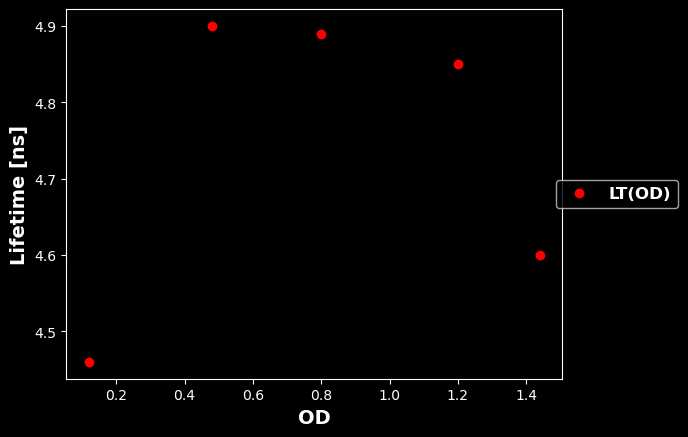

In [103]:
# plt.plot(x_reab_od,y_reab_lt_1,'bo',label='LT(OD), Try: 1')
plt.plot(data['optische Dichte'],data['t in ns.1'],'ro',label='LT(OD)')

plt.xlabel('OD', fontsize=14, fontweight='bold')
plt.ylabel('Lifetime [ns]', fontsize=14, fontweight='bold')

# Customize legend font size and weight
fontP = FontProperties()
fontP.set_size('large')  # Adjust 'large' as needed
fontP.set_weight('bold')

# Add a legend with custom font size and weight
plt.legend(loc='center right', bbox_to_anchor=(1.25, .5), prop=fontP)
# plt.savefig(f'Lifetime_OD.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

## LT Pheo in Wasser Ethanol

In [104]:
sheet_names

['1 SNR CFD',
 '2 PMT',
 '2.2 Laserint',
 '3 PileUp',
 '4 Reabsorp',
 '5 Pheo in EthWass',
 '6 EinbettMiz']

In [111]:
df_LT_Pheo = pd.read_excel(excel_file_path, sheet_names[5])
df_LT_Pheo = df_LT_Pheo.drop(0)
df_LT_Pheo.index = list(df_LT_Pheo['5 Pheophorbit in Ethanol-Wasser-Gemischen'])
df_LT_Pheo = df_LT_Pheo.drop('5 Pheophorbit in Ethanol-Wasser-Gemischen', axis=1)
df_LT_Pheo.columns = range(len(df_LT_Pheo.columns))
df_LT_Pheo = df_LT_Pheo.T
df_LT_Pheo

,Mischungsverhältnis P : W : E,chi^2,t in ns
0,1:0:4,1.312,4.9
1,1:1:3,20.93,3.08
2,1:2:2,36.25,0.0144
3,1:3:1,10.38,0.0008
4,1:4:0,3.201,0.0012


In [112]:
x = list(df_LT_Pheo['Mischungsverhältnis P : W : E'])
# x = x[::-1]
y = np.array(df_LT_Pheo['t in ns'])
# y = y[::-1]

In [113]:
print(type(x))
print(x)
print(y)

<class 'list'>
['1:0:4', '1:1:3', '1:2:2', '1:3:1', '1:4:0']
[4.9 3.08 0.0144 0.0008 0.0012]


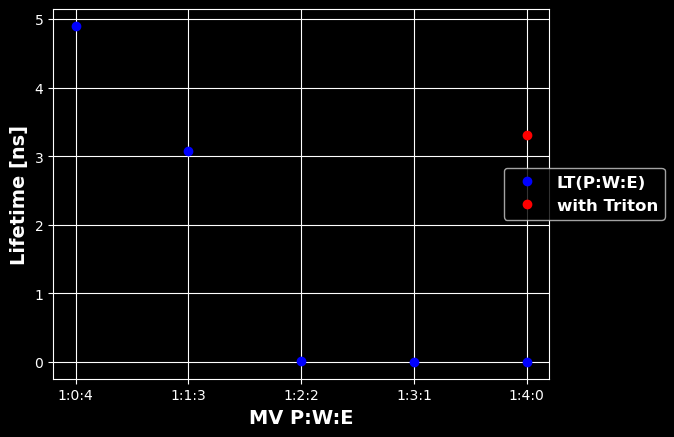

In [128]:
plt.plot(x, y, 'bo', label='LT(P:W:E)')
plt.plot(MV_140_mz, tau_miz, 'ro', label='with Triton')

plt.xlabel('MV P:W:E',fontsize=14,fontweight='bold')
plt.ylabel('Lifetime [ns]',fontsize=14,fontweight='bold')

# Customize legend font size and weight
fontP = FontProperties()
fontP.set_size('large')  # Adjust 'large' as needed
fontP.set_weight('bold')

# Add a legend with custom font size and weight
plt.legend(loc='center right',bbox_to_anchor=(1.25,.5),prop=fontP)
# plt.savefig(f'Lifetime_MV.png',dpi=600,transparent=True,bbox_inches = 'tight')
plt.grid()
plt.show()

## Lebensdauer (Reab)

In [ ]:
# # df_sheet_reab = pd.read_csv('4 Reabsorp.csv')
# df_sheet_reab = df_sheet_reab.drop([
#     'Position 5,2 verwendet',
#     'Unnamed: 1',
#     'chi^2',
#     't in ns',
#     'Unnamed: 6'
#     ],axis=1)
# df_sheet_reab = df_sheet_reab.drop([5,6],axis=0)
# df_sheet_reab = df_sheet_reab.rename(columns={
#     'Mischungsverhältnis P : E':'MV P:E',
#     'optische Dichte':'OD',
#     'chi^2.1':'chi^2',
#     't in ns.1':'tau [ns]'
# })
# df_sheet_reab

,MV P:E,OD,chi^2,tau [ns]
0,3:2,1.44,1.151,4.60
1,1:1,1.2,1.233,4.85
2,1:2,0.8,1.32,4.89
3,1:4,0.48,1.312,4.90
4,1:19,0.12,1.304,4.46


## MSE

In [ ]:
# Comp_value = 6.1

In [ ]:
# y_reab = np.array(data['t in ns.1'])
# y_pu = np.array(df_sheet_pu['tau [ns]'])

In [ ]:
# mse_reab,l1 = math_func.mse(y_reab, Comp_value)
# mse_pu,l2 = math_func.mse(y_pu, Comp_value)

In [ ]:
# l2

9

In [ ]:
# mse_reab

1.8812399999999994

In [ ]:
# mse_pu

1.544755555555555

## RMSE

In [ ]:
# rmse_reab = math_func.rmse(y_reab, Comp_value)
# print(rmse_reab)
# rmse_pu = math_func.rmse(y_pu, Comp_value)
# print(rmse_pu)

1.3715830270165927
1.2428819555997885


## Varianz und Standardabweichung

In [ ]:
# x = np.array([4.85,4.89,4.9])
# mu = x.sum()/3
# var =0
# for i in x:
#   var+= (i-mu)**2/3

# std = np.sqrt(var)
# print(f'Varianz: {var}')
# print(f'Std: {std}')

Varianz: 0.0004666666666666763
Std: 0.02160246899469309


In [ ]:
# np.sqrt(0.00047)

0.0216794833886788

# Apparatefunktion

## Data

In [131]:
csv_file_path = data_path + 'CSV-Files/'
csv_file_path

'../Data/CSV-Files/'

In [132]:
df_AF = pd.read_csv(csv_file_path + 'AF.csv')
df_AF.head()

,45,Time
0,7,0.000000
1,4,0.024438
2,9,0.048876
3,5,0.073314
4,7,0.097752


## Plot

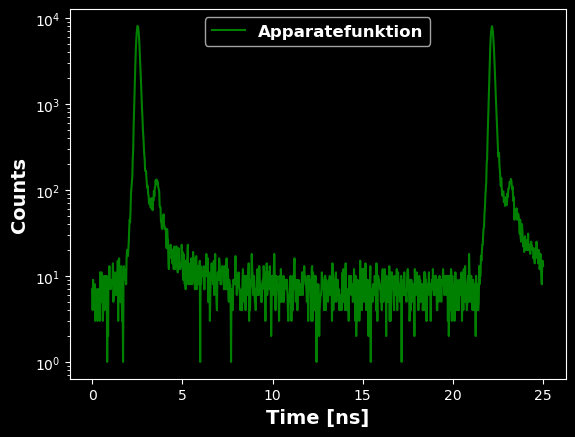

In [133]:
plt.plot(df_AF['Time'],df_AF['45'],color='green',label='Apparatefunktion')
plt.xlabel('Time [ns]',fontsize=14,fontweight='bold')
plt.ylabel('Counts',fontsize=14,fontweight='bold')
plt.yscale('log')
# Customize legend font size and weight
fontP = FontProperties()
fontP.set_size('large')  # Adjust 'large' as needed
fontP.set_weight('bold')

# Add a legend with custom font size and weight
plt.legend(prop=fontP)
# plt.savefig(f'{path}/AF.png',dpi=600,transparent=True,bbox_inches = 'tight')
plt.show()

# Pile - Up

## Data

In [162]:
df_pu = pd.read_csv(csv_file_path + 'Pile-Up-Effekt.csv')
df_pu = df_pu.drop('Unnamed: 0', axis=1)
df_pu.head()

,50,47,45,53,49,52,46,51,48,Time,AF
0,108,22,17,47,75,9,18,118,48,0.000000,3
1,111,27,11,37,88,12,18,120,52,0.024438,8
2,97,29,11,42,88,9,16,116,45,0.048876,5
3,113,42,10,45,70,9,18,129,61,0.073314,9
4,107,40,13,31,77,3,22,108,47,0.097752,5


## Plot

9
9


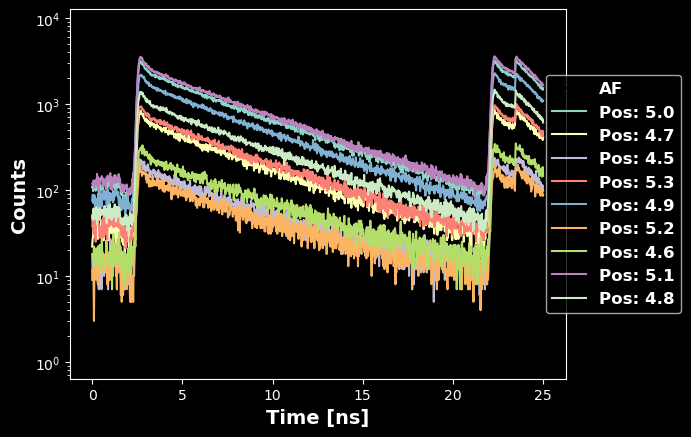

In [ ]:
x_pu = df_pu['Time']
y_pu = df_pu['AF']

labels = ['Pos: 5.0', 'Pos: 4.7',
    'Pos: 4.5',
    'Pos: 5.3',
    'Pos: 4.9',
    'Pos: 5.2',
    'Pos: 4.6',
    'Pos: 5.1',
    'Pos: 4.8']
cols_names = df_pu.columns
print(len(labels))
cols_names = list(cols_names[:9])
print(len(cols_names))
plt.plot(x_pu, y_pu, color='k', label='AF')
fpr.plotting_gen_with_labels(df_pu, cols_names, labels)
plt.show()

## Regression

In [ ]:
# def exp_test(t,t0,n0,tau):
#   return n0*np.exp(-(t-t0)/tau)

In [ ]:
# df_pu.columns

In [142]:
t = np.array(df_pu['Time'])
y50 = np.array(df_pu['50'])

t = t[:800]
# print(t)
y50 = np.log(y50[:800])


In [143]:
# test, dtest = curve_fit(exp_test,t,y50)
# t0,n0,tau = test
# print(test)

## Regression 2.0

In [144]:
def fun(t, t0, n0, tau):
    return n0 * np.exp(-(t - t0) / tau)

In [163]:
# help(lf.tcspc.fit)

In [156]:
print(len(t))
print(len(y50))

800
800


In [159]:
lf.tcspc.fit(fun, t, y50, [0, 5, 10])

(array([  0.35277831,   6.670627  , 105.59519677]),
 array([1.00146994e+06, 6.32645486e+04, 1.04193900e+01]))

In [160]:
# lf.tcspc.

In [161]:
# test = lf.tcspc.Lifetime(y50,t)

## bmp to png

In [ ]:
# path_bmp = '/content/BMP'
# out_dir = '/content/BMP/png'

In [ ]:
# files = os.listdir(path_bmp)
# for file in files:
#   if os.path.isfile(os.path.join(path_bmp,file)):
#     file_name  = os.path.splitext(file)[0]
#     new_file_name = file_name + '.png'
#     # Generate the full file paths
#     old_file_path = os.path.join(path_bmp, file)
#     new_file_path = os.path.join(path_bmp, new_file_name)

#     # Rename the file
#     os.rename(old_file_path, new_file_path)

# Reabsorption

## Data

In [164]:
# !wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Reabsorption.zip
# !unzip Reabsorption.zip

In [165]:
df_reab = pd.read_csv(csv_file_path + 'Reabsorption.csv')
df_reab = df_reab.drop('Unnamed: 0', axis=1)
df_reab.head()

,pe-3-2,pe-1-2,pe-1-1,52,pe-1-4,Time,AF
0,14,12,12,9,12,0.000000,3
1,17,14,14,12,11,0.024438,8
2,11,17,12,9,11,0.048876,5
3,8,12,16,9,15,0.073314,9
4,8,19,12,3,20,0.097752,5


## Plot

In [167]:
df_reab_plot = df_reab
# df_reab_plot = df_reab_plot.drop(['52'],axis=1)
df_reab_plot = df_reab_plot.rename(columns={
    'pe-3-2': 'MV 3:2',
    'pe-1-2': 'MV 1:2',
    'pe-1-1': 'MV 1:1',
    'pe-1-4': 'MV 1:4',
    '52': 'MV 1:19'
})
df_reab_plot.head()

,MV 3:2,MV 1:2,MV 1:1,MV 1:19,MV 1:4,Time,AF
0,14,12,12,9,12,0.000000,3
1,17,14,14,12,11,0.024438,8
2,11,17,12,9,11,0.048876,5
3,8,12,16,9,15,0.073314,9
4,8,19,12,3,20,0.097752,5


In [171]:
labels = list(df_reab_plot.columns)
labels = labels[:5]
print(labels)
# help(fpr.plotting_gen_with_labels)

['MV 3:2', 'MV 1:2', 'MV 1:1', 'MV 1:19', 'MV 1:4']


In [172]:
x = df_reab_plot['Time']
y = df_reab_plot['AF']

In [173]:
min(y)

0

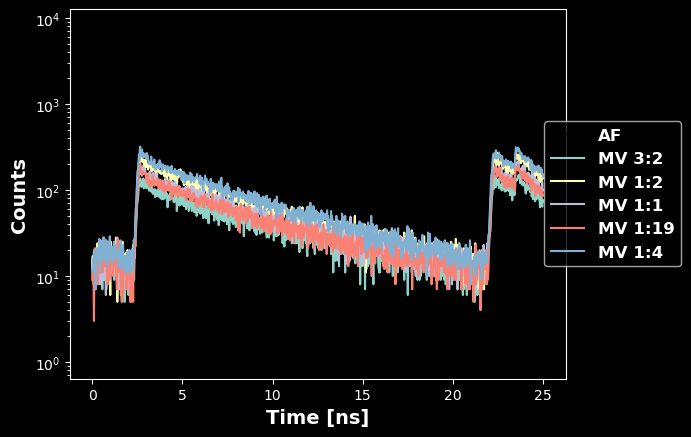

In [175]:
plt.plot(x, y, color='black', label='AF')
fpr.plotting_gen_with_labels(df_reab_plot, labels, labels)

# Fluoresenzslebesdauer
We used the plots from the experiment computer.

## Data

In [177]:
df_lebensdauer = df_reab_plot
df_lebensdauer = df_lebensdauer.drop([
    'MV 3:2',
    'MV 1:2',
    'MV 1:1'
], axis=1)
df_lebensdauer.head()

,MV 1:19,MV 1:4,Time,AF
0,9,12,0.000000,3
1,12,11,0.024438,8
2,9,11,0.048876,5
3,9,15,0.073314,9
4,3,20,0.097752,5


## Plot

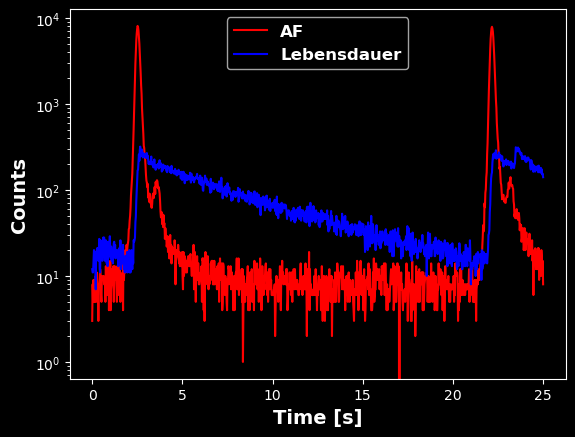

In [ ]:
plt.plot(x, y, color='red', label='AF')
plt.plot(df_lebensdauer['Time'], df_lebensdauer['MV 1:4'], color='blue', label='Lebensdauer')
plt.xlabel('Time [s]', fontsize=14, fontweight='bold')
plt.ylabel('Counts', fontsize=14, fontweight='bold')
plt.yscale('log')
# Customize legend font size and weight
fontP = FontProperties()
fontP.set_size('large')  # Adjust 'large' as needed
fontP.set_weight('bold')

# Add a legend with custom font size and weight
# plt.legend(loc='center right',bbox_to_anchor=(1.25,.5),prop=fontP)
plt.legend(prop=fontP)
# plt.savefig(f'{path}/AF.png',dpi=600,transparent=True,bbox_inches = 'tight')
plt.show()

## Regression

In [181]:
t = np.array(df_lebensdauer['Time'])
x_ld = np.array(df_lebensdauer['MV 1:4'])

In [182]:
# for i in [70]:
#   print(f'Time: {t[i]}')
#   print(f'LD: {x_ld[i]}')
#   print(f'Index: {i}')

In [183]:
# for i in [819,820]:
#   print(f'Time: {t[i]}')
#   print(f'LD: {x_ld[i]}')
#   print(f'Index: {i}\n')

In [184]:
t = t[70:819]
y_ld = x_ld[70:819]
# print(t)
# print(y_ld)

#### With statsmodels

In [185]:
# Add a constant term (intercept) to the features
# X = sm.add_constant(t)

# # Create the OLS model
# model = sm.OLS(y_ld, X)

# # Fit the model
# results = model.fit()

# print(results.summary())

#### with scipy

In [186]:
# help(curve_fit)

In [ ]:
# def reg(t, t0, N0):
#     N = N0 * np.exp(-(t - t0) / 4.90e-9) + c
#     return N

In [190]:
print(len(y_ld))
len(t)

749


749

In [191]:
# pop,cov=curve_fit(reg,t,y_ld,p0=[1, 5])#
# t0,N0=pop

In [192]:
# t0

It doesn't work.

# Pheo

## Data

In [193]:
# !wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Pheo_EWG.zip
# !unzip Pheo_EWG.zip

In [195]:
df_pheo = pd.read_csv(csv_file_path + 'Pheo_EWG.csv')
df_pheo = df_pheo.drop('Unnamed: 0', axis=1)
df_pheo = df_pheo.rename(columns={
    'pe-1-4-0': 'MV 1:4:0',
    'pe-1-2-2': 'MV 1:2:2',
    'pe-1-1-3': 'MV 1:1:3',
    'pe-1-3-1': 'MV 1:3:1',
    'pe-1-0-4': 'MV 1:0:4'
})
df_pheo.head()

,MV 1:4:0,MV 1:2:2,MV 1:1:3,MV 1:3:1,MV 1:0:4,Time,AF
0,3,15,20,2,12,0.000000,3
1,7,16,13,10,11,0.024438,8
2,9,16,15,10,11,0.048876,5
3,5,10,12,9,15,0.073314,9
4,7,22,16,11,20,0.097752,5


## Plot

['MV 1:4:0', 'MV 1:2:2', 'MV 1:1:3', 'MV 1:3:1', 'MV 1:0:4']


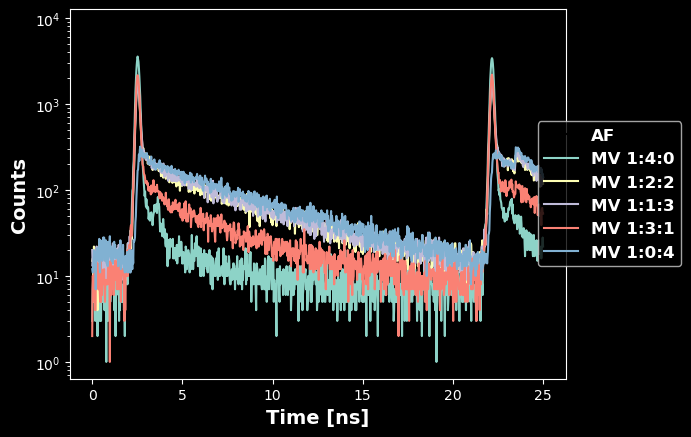

In [ ]:
x_pheo = df_pheo['Time']
y_pheo = df_pheo['AF']

labels = list(df_pheo.columns)
labels = labels[:5]
print(labels)
# help(fpr.plotting_gen_with_labels)

plt.plot(x_pheo, y_pheo, color='black', label='AF')
fpr.plotting_gen_with_labels(df_pheo, labels, labels)

# Triton

## Data

In [197]:
# !wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Triton.zip
# !unzip Triton.zip

In [199]:
df_triton = pd.read_csv(csv_file_path + 'Triton.csv')
df_triton = df_triton.drop('Unnamed: 0', axis=1)
df_triton = df_triton.rename(columns={
    'pe-1-0-4_0Grad': 'MV 1:0:4',
    '1-4-0_mit triton': 'MV 1:4:0'
})
df_triton.head()

,MV 1:0:4,MV 1:4:0,Time,AF
0,12,14,0.000000,3
1,11,11,0.024438,8
2,11,15,0.048876,5
3,15,18,0.073314,9
4,20,18,0.097752,5


## Plot

['MV 1:0:4', 'MV 1:4:0']


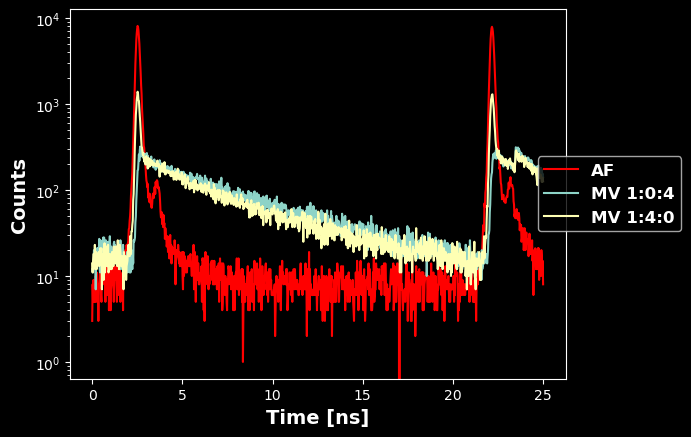

In [ ]:
x_t = df_triton['Time']
y_t = df_triton['AF']

labels = list(df_triton.columns)
labels = labels[:2]
print(labels)
# help(fpr.plotting_gen_with_labels)

plt.plot(x_t, y_t, color='red', label='AF')
fpr.plotting_gen_with_labels(df_triton, labels, labels,)

# Anisotropie

## Data

In [ ]:
# !wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip
# !unzip Anisotropie.zip

--2023-09-22 12:56:35--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip [following]
--2023-09-22 12:56:35--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14100 (14K) [application/zip]
Saving to: ‘Anisotropie.zip’

Anisotropie.zip     100%[===================>]  13.77K  --.-KB/s    in 0s      

2023-09-2

In [203]:
df_aniso = pd.read_csv(csv_file_path + 'Anisotropie.csv')
df_aniso = df_aniso.drop('Unnamed: 0', axis=1)
df_aniso = df_aniso.rename(columns={
    'pe-1-0-4_0Grad': 'ohne Triton 0°',
    'pe-1-0-4_90grad': 'ohne Triton 90°',
    '1-4-0_mit triton_90grad': 'mit Triton 90°',
    '1-4-0_mit triton_0Grad': 'mit Triton 0°'
})
df_aniso.head()

,ohne Triton 0°,ohne Triton 90°,mit Triton 90°,mit Triton 0°,Time,AF
0,12,13,12,14,0.000000,3
1,11,17,14,11,0.024438,8
2,11,19,6,15,0.048876,5
3,15,19,17,18,0.073314,9
4,20,16,10,18,0.097752,5


## Calculation
Equation:
$$ r = \frac{I_{||} - I_{\perp}}{I_{||} +2⋅ I_{\perp}} $$

In [204]:
ohne = math_func.anisotropie(df_aniso['ohne Triton 0°'], df_aniso['ohne Triton 90°'])
mit = math_func.anisotropie(df_aniso['mit Triton 0°'], df_aniso['mit Triton 90°'])

## Plot

['ohne Triton 0°', 'ohne Triton 90°', 'mit Triton 90°', 'mit Triton 0°']


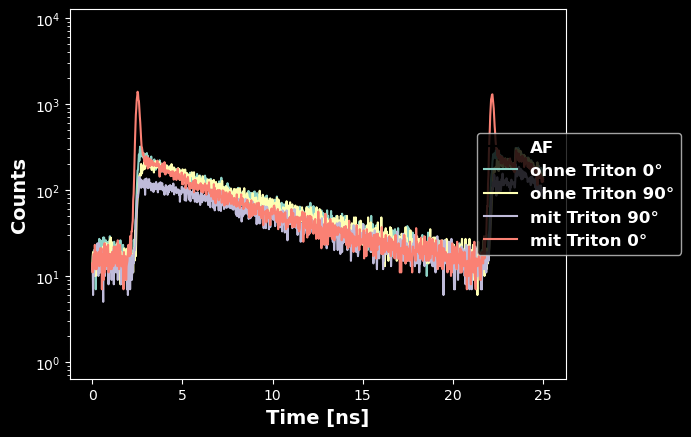

In [205]:
x_t = df_aniso['Time']
y_t = df_aniso['AF']

labels = list(df_aniso.columns)
labels = labels[:4]
print(labels)
# help(fpr.plotting_gen_with_labels)

plt.plot(x_t,y_t,color='black',label='AF')
fpr.plotting_gen_with_labels(df_aniso,labels,labels)

## Anisotropie

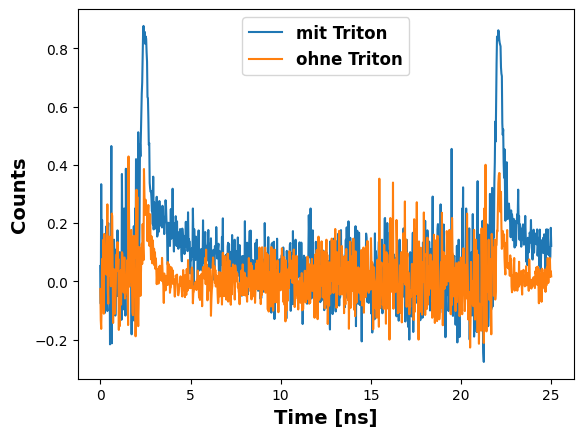

In [ ]:
# plot
plt.plot(x, mit, label='mit Triton')
plt.plot(x, ohne, label='ohne Triton')

# axis labels
plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
plt.ylabel('Counts', fontsize=14, fontweight='bold')

# Legend
fontP = FontProperties()
fontP.set_size('large')  # Adjust 'large' as needed
fontP.set_weight('bold')
plt.legend(prop=fontP)

# save plot
# plt.savefig(f'{path}/Anisotropie-Berechnet.png',dpi=600,transparent=True,bbox_inches = 'tight')
plt.show()

# Download all png files

In [ ]:
# # you must change this to your personal folder paths
# path_bmp = '/content/BMP'
# path_plots = '/content/Plots_1'

Allow Colab to download multiple files

In [ ]:
# from google.colab import files
# import shutil
# f1 = os.listdir(path_bmp)
# f2 = os.listdir(path_plots)

# for file in f1:
#   f_path = os.path.join(path_bmp, file)
#   # Get a list of all files in the folder

#   shutil.move(f_path, '/content')  # Move the file to /content for download
#   print(f'Downloading: {file}')
#   files.download(file)  # Trigger the download

# for file in f2:
#   f_path = os.path.join(path_plots, file)
#   # Get a list of all files in the folder

#   shutil.move(f_path, '/content')  # Move the file to /content for download
#   print(f'Downloading: {file}')
#   files.download(file)  # Trigger the download